In [28]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

total_data = pd.read_csv('./test.csv')

# Check the head of the features DataFrame
total_data.head()

,categoryNames,subTitle,title
0,"['Damesmode', 'Accessoires', 'Herenmode', 'Acc...","['Gemakkelijk om erbij te hebben, dit handige ...",['']
1,"['Computer', 'PC-Accessoires', 'Muismatten']",['Muismat - Mousepad - Rond - Druppels op een ...,['']
2,"['Elektronica', 'Telefonie & Accessoires', 'Te...",['Casimoda® - iPhone 11 Pro Max hoesje - Luipa...,['']
3,"['Wonen', 'Woonaccessoires', 'Wanddecoratie', ...",['Canvas - Schilderij - Tempel - Bergen - Natu...,['']
4,"['Auto & Motor', 'Scooter accessoires', 'Scoot...",['Axxis Square S helm mat titanium XS'],['']


In [29]:
unique_categories = set()
for categories in total_data['categoryNames']:
    # categories = categories.replace("'", '"')  # Replace single quotes with double quotes
    categories_list = eval(categories)
    unique_categories.update(categories_list)


# Create a new DataFrame with separate columns for each category
new_columns = {category: [] for category in unique_categories}
for categories in total_data['categoryNames']:
    for category in unique_categories:
        new_columns[category].append(1 if category in categories else 0)

# Filter out duplicate columns
new_df = pd.DataFrame(new_columns).groupby(level=0, axis=1).max()

# Concatenate the new DataFrame with the original DataFrame
new_data_set = pd.concat([total_data, new_df], axis=1)

# Drop the 'categoryNames' column

new_data_set.head()

/var/folders/by/djl8kvc52ld9qg8th41vmw7h0000gn/T/ipykernel_14997/3760568168.py:15: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  new_df = pd.DataFrame(new_columns).groupby(level=0, axis=1).max()


,categoryNames,subTitle,title,1600 tot 1800,1800 tot 1900,1900 tot 2000,2-zitsbanken,2000 tot nu,"3,5 zitsbanken",3-zitsbanken,...,Zwemaccessoires,Zwembaden,Zwembaden & Accessoires,Zwembanden,Zwembroeken,Zwemkleding,Zwemmen,Zwemtassen,klem oorbellen -zilverkleur -tak-lang- geen gaatje- Charme Bijoux,"laFeltrinelli Confidenze Troppo Intime DVD Frans, Italiaans"
0,"['Damesmode', 'Accessoires', 'Herenmode', 'Acc...","['Gemakkelijk om erbij te hebben, dit handige ...",[''],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"['Computer', 'PC-Accessoires', 'Muismatten']",['Muismat - Mousepad - Rond - Druppels op een ...,[''],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"['Elektronica', 'Telefonie & Accessoires', 'Te...",['Casimoda® - iPhone 11 Pro Max hoesje - Luipa...,[''],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"['Wonen', 'Woonaccessoires', 'Wanddecoratie', ...",['Canvas - Schilderij - Tempel - Bergen - Natu...,[''],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"['Auto & Motor', 'Scooter accessoires', 'Scoot...",['Axxis Square S helm mat titanium XS'],[''],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
x=new_data_set.iloc[:,3:].sum()
rowsums=new_data_set.iloc[:,3:].sum(axis=1)
no_label_count = 0
for sum in rowsums.items():
    if sum==0:
        no_label_count +=1

print("Total number of items = ",len(new_data_set))
print("Total number of items without label = ",no_label_count)
print("Total labels = ", x.sum())

Total number of items =  10009
Total number of items without label =  0
Total labels =  51804


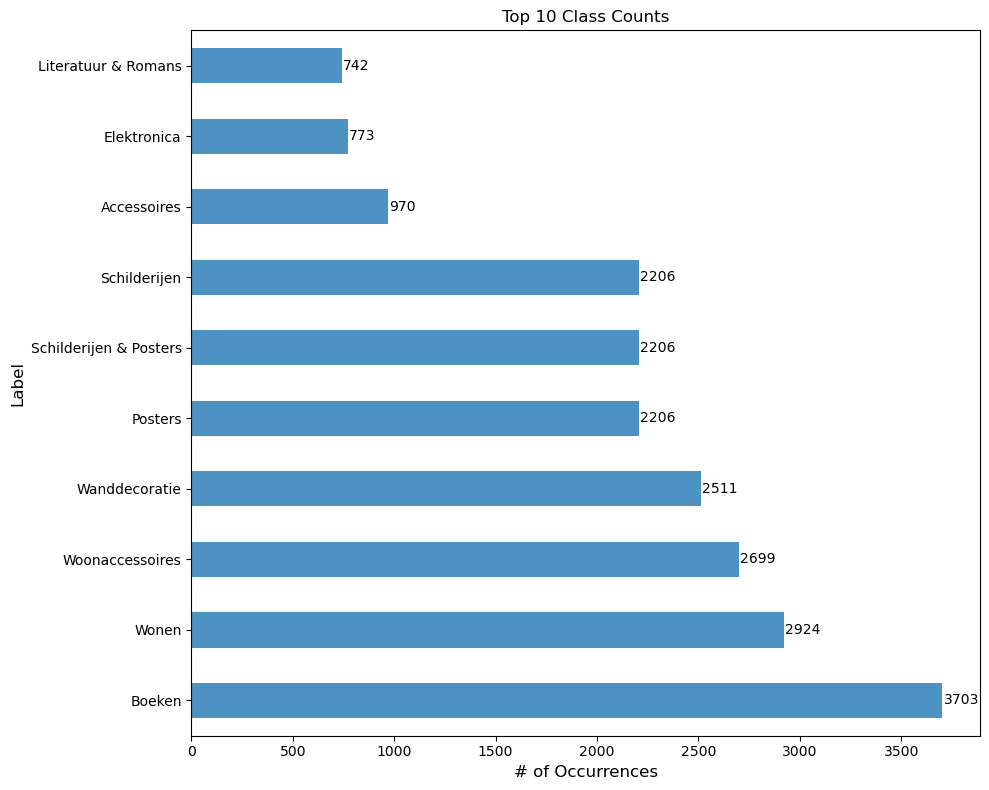

In [31]:
import matplotlib.pyplot as plt

x = new_data_set.iloc[:, 3:].sum()

# Sort the data in descending order
x_sorted = x.sort_values(ascending=False)

# Set the number of labels to display
num_labels = 10  # Adjust the number as needed

# Select the top 'num_labels' labels and their corresponding values
x_top = x_sorted[:num_labels]

plt.figure(figsize=(10, 8))
ax = x_top.plot(kind='barh', alpha=0.8)

plt.title("Top {} Class Counts".format(num_labels))
plt.xlabel('# of Occurrences', fontsize=12)
plt.ylabel('Label', fontsize=12)

# Add data value labels to the bars
for i, v in enumerate(x_top.values):
    ax.text(v + 5, i, str(v), va='center')

plt.tight_layout()
plt.show()

In [32]:
new_data_set['Text']=new_data_set['title']+' '+new_data_set['subTitle']
new_data_set.drop(columns=['categoryNames','title','subTitle'], inplace=True)
new_data_set.head(10)


,1600 tot 1800,1800 tot 1900,1900 tot 2000,2-zitsbanken,2000 tot nu,"3,5 zitsbanken",3-zitsbanken,3D-printer reserveonderdelen,3D-printeraccessoires,3D-printers & Accessoires,...,Zwembaden,Zwembaden & Accessoires,Zwembanden,Zwembroeken,Zwemkleding,Zwemmen,Zwemtassen,klem oorbellen -zilverkleur -tak-lang- geen gaatje- Charme Bijoux,"laFeltrinelli Confidenze Troppo Intime DVD Frans, Italiaans",Text
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[''] ['Gemakkelijk om erbij te hebben, dit han..."
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[''] ['Muismat - Mousepad - Rond - Druppels op...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[''] ['Casimoda® - iPhone 11 Pro Max hoesje - ...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[''] ['Canvas - Schilderij - Tempel - Bergen -...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[''] ['Axxis Square S helm mat titanium XS']
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[''] ['Poster Quotes - Spreuken - Little baby ...
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[''] ['Poster Glanzend – Panter met Grote Klau...
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[''] ['Behang - Fotobehang Piramide - Egypte -...
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[''] ['PVC Schuimplaat Hexagon - IJsbergen lan...
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[''] ['Jean-Jacques Palix - Film (CD)']


In [33]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

nltk.download('stopwords')

languages = set(['Arabic', 'Danish', 'Dutch', 'English', 'Finnish', 'French', 'German', 'Hungarian', 'Italian', 'Norwegian', 'Portuguese', 'Romanian', 'Russian', 'Spanish', 'Swedish'])
custom_stop_words = set()


for language in languages:
    # Remove Stopwords
    stop_words = set(stopwords.words(language.lower()))

    # Update the custom_stop_words set with stop_words for each language
    custom_stop_words.update(stop_words)

    # Function to remove stopwords from a list of words
    def remove_stopwords(text):
        no_stopword_text = [w for w in text if not w in stop_words]
        return no_stopword_text

    # Clean Text: Remove non-alphabetic characters and extra whitespaces from a list of words
    def clean_text(text):
        text = [re.sub("[^a-zA-Z]"," ", t) for t in text]
        text = [' '.join(t.split()) for t in text]
        return text

    # Stemming: Apply stemming to a list of words
    stemmer = SnowballStemmer(language.lower())
    def stemming(sentence):
        if isinstance(sentence, str):
            stemSentence = ""
            for word in sentence.split():
                stem = stemmer.stem(word)
                stemSentence += stem
                stemSentence += " "
            stemSentence = stemSentence.strip()
            return stemSentence
        else:
            return sentence

    # Apply text preprocessing functions to 'Text' column
    new_data_set['Text'] = new_data_set['Text'].apply(lambda x: remove_stopwords(x) if isinstance(x, list) else x)
    new_data_set['Text'] = new_data_set['Text'].apply(lambda x: clean_text(x) if isinstance(x, list) else x)
    new_data_set['Text'] = new_data_set['Text'].apply(stemming)
    print(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessehuijts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'stemmo', 'avessi', 'tutti', 'stavate', 'vostro', 'avessimo', 'era', 'abbiate', 'dello', 'dell', 'quella', 'ho', 'sue', 'hanno', 'sarei', 'tra', 'nella', 'stareste', 'hai', 'stesse', 'abbia', 'c', 'sarà', 'dei', 'avete', 'ci', 'faresti', 'i', 'facemmo', 'starei', 'avute', 'erano', 'anche', 'sta', 'fossero', 'alla', 'come', 'stavano', 'ero', 'facciamo', 'ha', 'dagli', 'nel', 'mi', 'gli', 'coi', 'che', 'nello', 'lui', 'avrete', 'fossimo', 'avesti', 'la', 'avrei', 'facevi', 'stavamo', 'suo', 'dall', 'essendo', 'vostra', 'in', 'facesti', 'dove', 'stiate', 'faceva', 'è', 'questo', 'stette', 'noi', 'avresti', 'farei', 'fossi', 'suoi', 'farò', 'dai', 'quelle', 'stava', 'avevano', 'degl', 'ma', 'avesse', 'starò', 'saresti', 'lo', 'avrà', 'voi', 'vostri', 'avevo', 'avranno', 'avendo', 'siano', 'tua', 'fai', 'facciate', 'mie', 'tu', 'avrebbero', 'sia', 'fosti', 'aveste', 'farebbero', 'staresti', 'stesti', 'faccia', 'fanno', 'faremmo', 'facevo', 'cui', 'stiamo', 'quanto', 'queste', 'starebbe', '

In [34]:
print(custom_stop_words)

{'إليكَ', 'علم', 'joksi', 'utolsó', 'abbiate', "aren't", 'zich', 'قد', 'fora', 'мне', 'abbia', 'nouă', 'مافتئ', 'seriam', 'joiksi', 'مع', 'aie', 'fuesen', 'ح', 'het', 'benne', 'между', 'nuestras', 'قاطبة', 'eine', 'nel', 'suas', 'millä', 'esse', 'shouldn', 'coi', 'كأي', 'm', 'tuvo', 'هَاتِي', 'سرعان', 'أربعمائة', 'then', 'صبرا', 'sille', 'tuviera', 'diese', 'estemos', 'anume', 'или', 'ki', 'حار', 'éppen', "you'll", 'منها', 'إذن', 'هن', 'pela', 'olisin', 'هاته', 'ذَيْنِ', 'noua', 'habidas', 'vostri', 'was', 'houve', 'fai', 'tendréis', 'keille', 'iemand', 'también', 'anderer', 'fosti', 'fel', 'перед', 'nos', 'вам', 'hay', 'sentido', 'eus', 'houverá', 'hvilken', 'بنا', 'أجل', 'itself', 'auraient', 'aurais', "won't", 'pot', 'وإن', 'blive', 'nå', 'the', 'noen', 'ش', 'dich', 'na', 'deci', 'nuestro', 'da', 'لاسيما', 'estarás', 'à', 'questi', 'دواليك', 'keiner', 'nostra', 'meinem', 'كل', "hadn't", 'будет', 'estén', 'leur', 'صراحة', 'بطآن', 'tot', 'هلا', 'даже', 'tenha', 'hubieses', 'ihren', 'a

In [35]:
print(new_data_set['Text'])

0        [''] ['gemakkelij om erbij te hebben, di han 1...
1        [''] ['muis mousep ron drup op een blauw blad ...
2        [''] ['casimoda® iph 11 pro max hoesj luip gri...
3        [''] ['canv schilderij tempel berg natur oil p...
4                     [''] ['ax squ s hel mat titaniu xs']
                               ...                        
10004                       [''] ['le nou espr solidaire']
10005                                       [''] ['peace']
10006    [''] ['pvc schuimpl hexag chihuahu hon met kla...
10007    ['micr charg de whis de cel et matric p ou pla...
10008                              [''] [ьи̇нсаноğл и̇саь]
Name: Text, Length: 10009, dtype: object


In [36]:

# Remove the [''] substring from the 'Text' column
new_data_set['Text'] = new_data_set['Text'].apply(lambda x: x.replace("['']", "") if not isinstance(x, float) else x)

new_data_set = new_data_set.dropna(subset=['Text'])

new_data_set['Text'] = new_data_set['Text'].apply(lambda x: re.sub(r'\W+', ' ', str(x)))
new_data_set['Text'] = new_data_set['Text'].apply(lambda x: re.sub(r'\d+', '', str(x)))  




In [37]:
X = new_data_set['Text']

new_data_set.drop(columns=['Text'], inplace=True)

y = new_data_set

print(X)
print(y)

0         gemakkelij om erbij te hebben di han vak knip...
1         muis mousep ron drup op een blauw blad x cm r...
2         casimoda iph  pro max hoesj luip grij silicon...
3         canv schilderij tempel berg natur oil pain x ...
4                             ax squ s hel mat titaniu xs 
                               ...                        
10004                               le nou espr solidaire 
10005                                               peace 
10006     pvc schuimpl hexag chihuahu hon met klap poot...
10007     micr charg de whis de cel et matric p ou pla ...
10008                                    ьи нсаноğл и саь 
Name: Text, Length: 9949, dtype: object
       1600 tot 1800  1800 tot 1900  1900 tot 2000  2-zitsbanken  2000 tot nu  \
0                  0              0              0             0            0   
1                  0              0              0             0            0   
2                  0              0              0             0    

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25) # by default train_test_split uses 25% of the data for the test set

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7461,), (2488,), (7461, 3062), (2488, 3062))

In [39]:
# print(X_train)
print(y_train)

y_train.to_csv('./y_train.csv')

      1600 tot 1800  1800 tot 1900  1900 tot 2000  2-zitsbanken  2000 tot nu  \
8551              0              0              0             0            0   
5944              0              0              0             0            0   
3147              0              0              0             0            0   
4232              0              0              0             0            0   
2127              0              0              0             0            0   
...             ...            ...            ...           ...          ...   
3635              0              0              0             0            0   
4175              0              0              0             0            0   
5181              0              0              0             0            0   
3188              0              0              0             0            0   
8030              0              0              0             0            0   

      3,5 zitsbanken  3-zitsbanken  3D-

In [41]:
custom_stop_words_list = list(custom_stop_words)

pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=custom_stop_words_list)),
                ('clf',  LabelPowerset(LogisticRegression(max_iter=120))),
            ])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

print("Accuracy = ",accuracy_score(y_test,predictions))
print('F1 score is ',f1_score(y_test, predictions, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, predictions))


/Users/jessehuijts/Desktop/ml-hello-world/env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


Accuracy =  0.37741157556270094
F1 score is  0.6003998857469294
Hamming Loss is  0.0011018269798232037


In [63]:
predictions = pipeline.predict(['ASUS VivoBook M1605YA-MB451W - Laptop - 16 inch'])

print("Predicted labels:", predictions)

Predicted labels:   (0, 508)	1
  (0, 1488)	1
  (0, 2549)	1
  (0, 2550)	1


In [64]:

# Assuming you have a DataFrame called 'df'
column_index = 508

# Search for the column index in the DataFrame
column_name = y_train.columns[column_index]

# Print the column name
print(column_name)

Computer


In [65]:
from joblib import dump, load

# Save a model to file
file_name_model_joblib = "logistic_regression_model.joblib"
dump(pipeline, filename=file_name_model_joblib) 

['logistic_regression_model.joblib']

In [66]:
loaded_joblib_model = load(filename=file_name_model_joblib)

In [67]:
joblib_model_prediction = loaded_joblib_model.predict(['Beyoncé - Cowboy Carter (CD)'])

print("Predicted labels:", joblib_model_prediction)

Predicted labels:   (0, 462)	1
  (0, 1346)	1
  (0, 1732)	1


/Users/jessehuijts/Desktop/ml-hello-world/env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


In [70]:

column_index = 1732

# Search for the column index in the DataFrame
column_name = y_train.columns[column_index]

# Print the column name
print(column_name)

Muziek
